In [2]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install albumentations --user

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import copy
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as tf
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

%matplotlib inline
sns.set_style("dark")

In [5]:
import os
current_dir = os.getcwd()

In [3]:
import zipfile
import os
import shutil

current_dir = os.getcwd()

zip_file_path = os.path.join(current_dir, 'dataset.zip')
extract_to = current_dir 

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files have been extracted to {extract_to}")

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Traffic-classification-intensity-estimation\\dataset.zip'

In [9]:
images_dir=os.path.join(current_dir, 'dataset/images/train')
labels_dir=os.path.join(current_dir, 'dataset/labels/train')

classes=["background","Auto","Bus","Car","LCV","Motorcycle","Truck","Tractor","Multi-Axle"]

num_classes=9
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=50
learning_rate=3e-5

model_weights_file="model.pth"

threshold=0.3
iou_threshold=0.8

In [10]:
import torch
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1650


In [11]:
import pandas as pd
import seaborn as sns
dict_instances=dict(zip(list(range(8)),[0]*8))
cols=["Labels","xcenter","ycenter","width","height"]

for label_file_name in os.listdir(labels_dir):
    label_file_path=os.path.join(labels_dir,label_file_name)

    try:
        label_data=pd.read_csv(label_file_path,delimiter=" ",header=None)
        labels_count=label_data[0].value_counts()

        for idx in labels_count.index:
            dict_instances[idx]+=labels_count[idx]
    except:
        continue

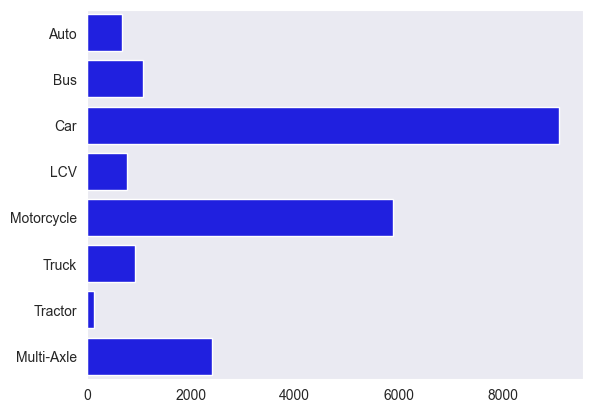

In [12]:
sns.barplot(y=classes[1:],x=list(dict_instances.values()),color="blue");
plt.savefig(os.path.join(current_dir, 'ssd_model/1.png'))

In [13]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=15,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),
                           A.CLAHE(),
                           A.GaussNoise()],
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.7,
                                                   label_fields=["labels"]))

In [14]:
class Vehicle(Dataset):
    def __init__(self,imgs_dir,annot_dir,transform=None):
        super().__init__()
        self.imgs_dir=imgs_dir
        self.labels_dir=annot_dir
        self.imgs_list=sorted([img_name for img_name in os.listdir(self.imgs_dir)
                               if img_name.endswith(".jpg")])
        self.transform=transform

    def __len__(self):
        return len(self.imgs_list)

    def __getitem__(self,idx):
        img_name=self.imgs_list[idx]
        img_path=os.path.join(self.imgs_dir,img_name)
        img=Image.open(img_path)
        w,h=img.size
        img=np.asarray(img)

        try:
            annot_name=img_name[:-4]+".txt"
            annot_path=os.path.join(self.labels_dir,annot_name)
            annot_data=pd.read_csv(annot_path,delimiter=" ",header=None).values
            labels=annot_data[:,0]
            labels=labels+1
            boxes=annot_data[:,1:5]

            xmin=((boxes[:,0]-boxes[:,2]/2)*w)[:,None]
            ymin=((boxes[:,1]-boxes[:,3]/2)*h)[:,None]
            xmax=((boxes[:,0]+boxes[:,2]/2)*w)[:,None]
            ymax=((boxes[:,1]+boxes[:,3]/2)*h)[:,None]
            boxes=np.concatenate((xmin,ymin,xmax,ymax),axis=1)

            if self.transform is not None:
                transformed=self.transform(image=img,bboxes=boxes,labels=labels)
                img=transformed["image"]
                boxes=transformed["bboxes"]
                labels=transformed["labels"]

            if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
                boxes=[[0.0,0.0,1.0,1.0]]
                labels=[0]

        except:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]

        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)

        return img,target

In [15]:
train_ds=Vehicle(images_dir,labels_dir,train_transform)
val_ds=Vehicle(images_dir,labels_dir)

In [16]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.8*len(train_ds))]
val_idx=idxs[int(0.8*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

In [17]:
def show_bbox(img,target,axis,color=(0,255,0)):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    axis.imshow(img)
    axis.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


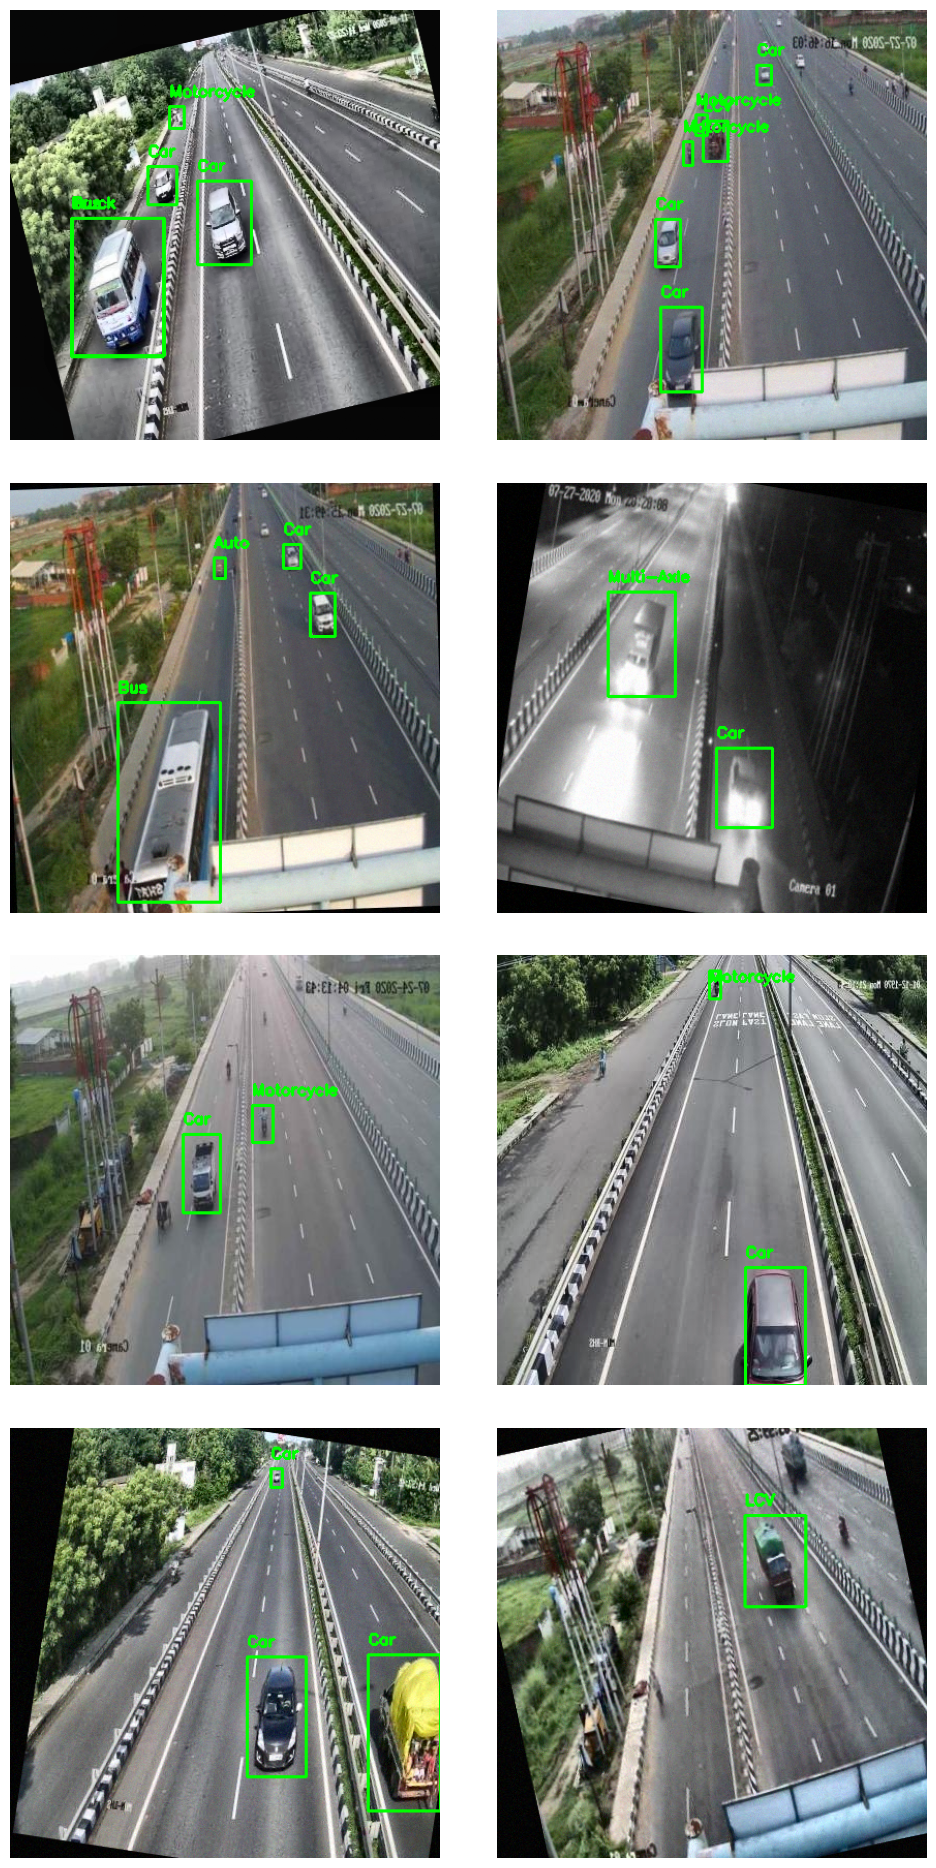

In [18]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)

for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    show_bbox(img,target,axis=ax[i])

plt.savefig(os.path.join(current_dir, 'ssd_model/2.png'))

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [20]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

In [21]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels=det_utils.retrieve_out_channels(model.backbone,(300,300))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [22]:
for params in model.backbone.features.parameters():
    params.requires_grad=False

parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)

In [23]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [ ]:
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    training_loss=0.0
    validation_loss=0.0

    current_lr=get_lr(optimizer)

    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()


    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)

    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")


    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)

    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

torch.save(best_weights,model_weights_file)

In [ ]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

In [24]:
model_learned_weights=os.path.join(current_dir, 'ssd_model/model.pth')
model=ssd300_vgg16(weights=None,weights_backbone=None)

in_channels=det_utils.retrieve_out_channels(model.backbone,(300,300))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_learned_weights,map_location=device))
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [25]:
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""

    processed_bbox={}

    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)

    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]

    return processed_bbox

In [ ]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in val_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        predictions=model(imgs)

        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))

        metric.update(results,targets)

results=metric.compute()

In [ ]:
if (len(results["map_per_class"])==len(classes)):
    map_per_class=results["map_per_class"][1:].tolist()
    mar_100_per_class=results["mar_100_per_class"][1:].tolist()
    obj_cls=classes[1:]
else:
    map_per_class=results["map_per_class"].tolist()
    mar_100_per_class=results["mar_100_per_class"].tolist()
    obj_cls=classes[1:]

data=list(zip(map_per_class,mar_100_per_class))
columns=["Mean_Avg_Precision","Mean_Avg_Recall"]
cls_map=pd.DataFrame(data,columns=columns,index=obj_cls)
cls_map.style.background_gradient(subset=columns,cmap="YlOrRd",high=0.75)

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

def count_vehicle_types(prediction, class_names):
    labels = prediction['labels'].cpu().numpy()  # Extract predicted labels
    label_counts = {class_name: 0 for class_name in class_names}  # Initialize count dictionary

    for label in labels:
        if label > 0 and label <= len(class_names):  # Ensure label is within class range
            label_counts[class_names[label - 1]] += 1  # Class labels start from 1 in SSD (0 is background)

    return label_counts

for i, idx in enumerate(range(len(imgs))):
    img = imgs[idx]
    prediction = output[idx]

    # Preprocess predictions
    predict = preprocess_bbox(prediction)

    # Count vehicle types in the current image
    vehicle_counts = count_vehicle_types(predict, classes)
    print(f"Image {idx}: {vehicle_counts}")

    # Visualization
    show_bbox(img, targets[idx], axes[i, 0], color=(0, 255, 0))  # Ground truth
    show_bbox(img, predict, axes[i, 1], color=(255, 0, 0))  # Predictions

plt.savefig("4.png")

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming 'val_dl' is your validation dataloader

# Set up a figure with subplots
fig, axes = plt.subplots(4, 2, figsize=(8, 16))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Get a batch of images and their corresponding targets from validation set
imgs, targets = next(iter(val_dl))  # Adjust 'val_dl' according to your dataloader

# Switch model to evaluation mode
model.eval()

# Disable gradient computation for inference
with torch.no_grad():
    # Perform inference on all images in the batch
    output = model([img.to(device) for img in imgs])

# Loop over images and predictions to visualize
for i, idx in enumerate(range(len(imgs))):
    img = imgs[idx]  # Original image
    prediction = output[idx]  # Model's prediction for the image

    # Show the real bounding boxes (ground-truth)
    show_bbox(img, targets[idx], axes[i, 0], color=(0, 255, 0))  # Green for ground-truth

    # Preprocess and show the predicted bounding boxes
    predict = preprocess_bbox(prediction)
    show_bbox(img, predict, axes[i, 1], color=(255, 0, 0))  # Red for predictions

# Save the figure as an image
plt.savefig("4.png")

In [ ]:
import cv2
import numpy as np

# Define a threshold for heavy traffic based on the weighted sum
heavy_traffic_threshold = 3.5  # Adjust this based on analysis

# PCU values for each vehicle type
pcu_values = {
    "Auto": 0.7,
    "Bus": 3.0,
    "Car": 1.0,
    "LCV": 1.5,
    "Motorcycle": 0.5,
    "Truck": 3.0,
    "Tractor": 2.0,
    "Multi-Axle": 4.5
}

# Define lane regions using vertices
vertices_left_lane = np.array([(523, 5), (55, 710), (632, 713), (657, 9)], dtype=np.int32)
vertices_right_lane = np.array([(692, 8), (772, 712), (1259, 589), (829, 9)], dtype=np.int32)

# Define region limits and thresholds
x1, x2 = 5, 715
lane_threshold = 670

# Text display positions
text_position_left_lane = (10, 50)
text_position_right_lane = (820, 50)
intensity_position_left_lane = (10, 210)
intensity_position_right_lane = (820, 210)

# Font settings
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)
background_color = (0, 0, 255)

# Load the video
cap = cv2.VideoCapture(os.path.join(current_dir, 'sample_video.mp4'))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(os.path.join(current_dir, 'sample_output1.avi'), fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        # Copy and mask irrelevant areas of the frame
        detection_frame = frame.copy()
        detection_frame[:x1, :] = 0
        detection_frame[x2:, :] = 0

        # Perform vehicle classification
        results = model.predict(detection_frame, imgsz=640, conf=0.4)
        processed_frame = results[0].plot(line_width=1)
        processed_frame[:x1, :] = frame[:x1, :].copy()
        processed_frame[x2:, :] = frame[x2:, :].copy()

        # Draw lane boundaries
        cv2.polylines(processed_frame, [vertices_left_lane], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.polylines(processed_frame, [vertices_right_lane], isClosed=True, color=(255, 0, 0), thickness=2)

        # Initialize counters for each lane
        vehicle_counts_left_lane = {vehicle_type: 0 for vehicle_type in results[0].names.values()}
        vehicle_counts_right_lane = {vehicle_type: 0 for vehicle_type in results[0].names.values()}

        # Process detections
        for box, label in zip(results[0].boxes.xyxy, results[0].boxes.cls):
            vehicle_type = results[0].names[int(label)]
            
            # Count vehicles based on lane
            if box[0] < lane_threshold:
                vehicle_counts_left_lane[vehicle_type] += 1
            else:
                vehicle_counts_right_lane[vehicle_type] += 1

        # Calculate PCU-weighted vehicle counts for each lane
        weighted_sum_left = sum(vehicle_counts_left_lane[vt] * pcu_values.get(vt, 1) for vt in vehicle_counts_left_lane)
        weighted_sum_right = sum(vehicle_counts_right_lane[vt] * pcu_values.get(vt, 1) for vt in vehicle_counts_right_lane)

        # Determine traffic intensity based on PCU-weighted sum
        traffic_intensity_left = "Heavy" if weighted_sum_left > heavy_traffic_threshold else "Smooth"
        traffic_intensity_right = "Heavy" if weighted_sum_right > heavy_traffic_threshold else "Smooth"

        # Display vehicle counts and traffic intensity
        for i, (vehicle_type, count) in enumerate(vehicle_counts_left_lane.items()):
            cv2.putText(processed_frame, f'{vehicle_type}: {count}', (text_position_left_lane[0], text_position_left_lane[1] + i * 20), font, font_scale, font_color, 1, cv2.LINE_AA)

        for i, (vehicle_type, count) in enumerate(vehicle_counts_right_lane.items()):
            cv2.putText(processed_frame, f'{vehicle_type}: {count}', (text_position_right_lane[0], text_position_right_lane[1] + i * 20), font, font_scale, font_color, 1, cv2.LINE_AA)

        # Display traffic intensity
        cv2.putText(processed_frame, f'Traffic Intensity Left: {traffic_intensity_left}', intensity_position_left_lane, font, font_scale, font_color, 2, cv2.LINE_AA)
        pcu_position_left_lane = (intensity_position_left_lane[0], intensity_position_left_lane[1] + 40)  
        cv2.putText(processed_frame, f'PCU Left Lane: {weighted_sum_left:.2f}', pcu_position_left_lane, font, font_scale, font_color, 2, cv2.LINE_AA)
        cv2.putText(processed_frame, f'Traffic Intensity Right: {traffic_intensity_right}', intensity_position_right_lane, font, font_scale, font_color, 2, cv2.LINE_AA)
        pcu_position_right_lane = (intensity_position_right_lane[0], intensity_position_right_lane[1] + 40)  
        cv2.putText(processed_frame, f'PCU Right Lane: {weighted_sum_right:.2f}', pcu_position_right_lane, font, font_scale, font_color, 2, cv2.LINE_AA)

        out.write(processed_frame)

    else:
        break

cap.release()
out.release()